In [1]:
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


import numpy as np
import io
import re
import string
import tqdm
import nltk
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
import contractions

import matplotlib.pyplot as plt

physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0],True)

2022-11-04 05:11:27.200792: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-04 05:11:27.200809: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-04 05:11:28.874875: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-04 05:11:28.875231: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-04 05:11:28.875274: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.s

In [2]:
%load_ext tensorboard
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

In [3]:
pd.set_option('display.max_colwidth', None)
df = pd.read_csv("./data/text_emotion.csv")

In [4]:
cleaned_df = df.copy()
# lowercasing 'content' column
cleaned_df['content'] = cleaned_df['content'].str.lower()

# tokenising words with nltk word tokeniser
# cleaned_df['content'] = cleaned_df['content'].apply(lambda sentence: " ".join(word_tokenize(sentence)))

# expanding contractions
cleaned_df['content'] = cleaned_df['content'].apply(lambda sentence: contractions.fix(sentence))

# remove anything http
cleaned_df['content'] = cleaned_df['content'].apply(lambda sentence: " ".join([re.sub('.*http.*','',word) for word in sentence.split()]))

# removing all words with #hastag and @name and urls
cleaned_df['content'] = cleaned_df['content'].apply(lambda sentence: " ".join([re.sub('@.*','',word) for word in sentence.split()]))
cleaned_df['content'] = cleaned_df['content'].apply(lambda sentence: " ".join([re.sub('#.*','',word) for word in sentence.split()]))
cleaned_df['content'] = cleaned_df['content'].apply(lambda sentence: " ".join([re.sub('.*www\..*','',word) for word in sentence.split()]))

# removing words with digits like game57
cleaned_df['content'] = cleaned_df['content'].apply(lambda sentence: re.sub('\w*\d+\w*','',sentence))


# removing all punctuation marks
exclude = set(string.punctuation)
regex = re.compile('[%s]' % re.escape(string.punctuation))
cleaned_df['content'] = cleaned_df['content'].apply(lambda sentence: regex.sub("",sentence))

# removing unicode characters
cleaned_df['content'] = cleaned_df['content'].apply(lambda sentence: sentence.encode("ascii","ignore").decode())

# removing stopwords
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
cleaned_df['content'] = cleaned_df['content'].apply(lambda sentence: " ".join([word for word in sentence.split() if word not in stop_words]))

# lemmatization
lemmatizer = WordNetLemmatizer()
cleaned_df['content'] = cleaned_df['content'].apply(lambda sentence: " ".join([lemmatizer.lemmatize(word) for word in sentence.split()]))

## Distribution of lengths of sentences

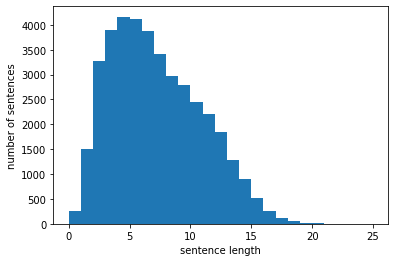

In [5]:
lengths = [len(sentence.split()) for sentence in cleaned_df['content']]

plt.hist(lengths,bins=len(set(lengths)))
plt.xlabel('sentence length')
plt.ylabel('number of sentences')

plt.show()

# One hot encoding labels

In [6]:
print('Unique labels:')
for i, label in enumerate(cleaned_df['sentiment'].unique()):
    print('{}) {}'.format(i,label)) 

Unique labels:
0) empty
1) sadness
2) enthusiasm
3) neutral
4) worry
5) surprise
6) love
7) fun
8) hate
9) happiness
10) boredom
11) relief
12) anger


### distribution of sentiments

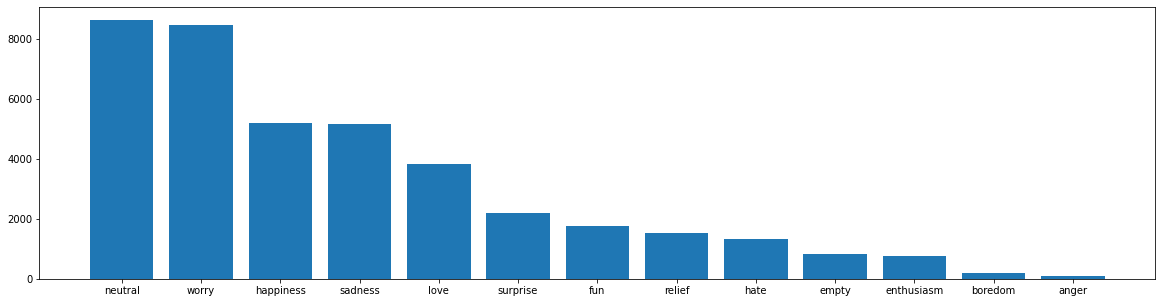

In [7]:
plt.rcParams['figure.figsize'] = [20, 5]
x= list(dict(cleaned_df.sentiment.value_counts()).keys())
y = list(cleaned_df.sentiment.value_counts())
plt.bar(x,y)
plt.show()

In [8]:
# map labels -> indices
sentiment_labels = cleaned_df['sentiment'].unique().copy()

# index key -> class
label_map = {}

# class -> index key
inverse_label_map = {}
for i, label in enumerate(sentiment_labels):
    label_map[i] = label 
    inverse_label_map[label] = i

In [9]:
# get all keys
indices = list(label_map.keys())
indices

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [10]:
# maps the word to the one hot vector
depth = len(indices)
one_hot_encoding = tf.one_hot(indices,depth)

2022-11-04 05:12:04.844284: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
word_to_vec = {}    
for i,oh in enumerate(one_hot_encoding):
    print("{} --> {}".format(oh,label_map[i]))
    word_to_vec[label_map[i]] = oh.numpy()

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] --> empty
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] --> sadness
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] --> enthusiasm
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] --> neutral
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] --> worry
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.] --> surprise
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.] --> love
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] --> fun
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] --> hate
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] --> happiness
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] --> boredom
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] --> relief
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] --> anger


In [12]:
word_to_vec

{'empty': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 'sadness': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 'enthusiasm': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 'neutral': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 'worry': array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 'surprise': array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 'love': array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32),
 'fun': array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32),
 'hate': array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32),
 'happiness': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32),
 'boredom': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32),
 'relief': array([0., 0., 0., 0., 0., 0.

In [13]:
# getting one-hot encoding for labels

labels=[]
for sentiment in tqdm.tqdm(cleaned_df['sentiment'].values):
    o_h = one_hot_encoding[inverse_label_map[sentiment]]
    labels.append(o_h)
labels = np.asarray(labels)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40000/40000 [00:04<00:00, 8679.54it/s]


In [14]:
# checking oh encoding is done right
for i,v in cleaned_df['sentiment'].items():
    if False in (word_to_vec[v] == labels[i]):
        print("Check failed")

# Converting 'content' column to word vectors
---

In [16]:
# if google EMBEDDING DIM is 300, Twitter, 50
EMBEDDING_DIM = 300

content_lines = list(cleaned_df['content'])
tokeniser_obj = Tokenizer()
tokeniser_obj.fit_on_texts(content_lines)
sequences = tokeniser_obj.texts_to_sequences(content_lines)

# pad sequences
word_index = tokeniser_obj.word_index
print('Found {} unique tokens'.format(len(word_index)))


content_pad = pad_sequences(sequences,maxlen=EMBEDDING_DIM)
# print("labels: {}".format(labels))

Found 31044 unique tokens


In [17]:
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words,EMBEDDING_DIM))

In [18]:
embedding_matrix.shape

(31045, 300)

# Reading embedded Google data
---
> takes awhile ...

In [19]:
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin',binary=True)

In [20]:
count_gnews = 0

corpus = model.index_to_key
for word,i in tqdm.tqdm(word_index.items()):
    if i> num_words:
        continue
    if word in corpus:
        embedding_vector_gnews = model[word]
        embedding_matrix[i] = embedding_vector_gnews
        count_gnews+=1
            
        
print("number of words vectorised from Gnews: {}/{}".format(count_gnews,num_words))
print("number of words vectorised from GloVe: {}/{}".format(count_gnews,num_words))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31044/31044 [11:32<00:00, 44.84it/s]

number of words vectorised from Gnews: 17052/31045
number of words vectorised from GloVe: 17052/31045


# Reading embedded Twitter vectors + custom trained w2v vectors
---

### Embeddings from Twitter:

In [ ]:
def read_twitter_embeddings_file(path):
    
    word_embedding_map = {}
    inverse_word_embedding_map = {}
    
    file = open(path,'r')
    vocab_size, embedding_dim = file.readline().split()
    vocab_size,embedding_dim = int(vocab_size),int(embedding_dim)
    print("vocab size:{}".format(vocab_size))
    print("vocab size:{}".format(embedding_dim))
    
    for i in tqdm.tqdm(range(vocab_size)):
    #while(True):
        line = file.readline()
        word,embedding = line.split()[0],line.split()[1:]
        
        if not line:
            break
        word_embedding_map[word] = embedding
        
    file.close()
    return word_embedding_map,vocab_size,embedding_dim

In [ ]:
word_embedding_map,vocab_size,_ = read_twitter_embeddings_file("./data/glove.twitter.27B.50d.txt")

### Embeddings from Custom w2v:

In [ ]:
def read_tsv(path):
    result = []
    file = open(path,'r')
    while (True):
        line = file.readline()
        if not line:
            break
        result.append([float(value) for value in line.split()])
        
    file.close()
    return result

In [ ]:
def read_meta(path):
    result = []
    file = open(path,'r')
    while (True):
        line = file.readline()
        if not line:
            break
            
        result.append(line.strip())
    file.close()
    return result

In [ ]:
vectors = read_tsv('./data/vectors1.tsv')
classes = read_meta('./data/metadata1.tsv')

In [ ]:
# make an inverse index of the classes name -> index
word_vector_map = {}
for index,word in enumerate(classes):
    word_vector_map[word] = vectors[index]

### Map embeddings to the embedding Matrix to feed into GRU Model

In [ ]:
count_glove = 0
count_w2v = 0

for word,i in word_index.items():
    if i> num_words:
        continue
    embedding_vector_glove = word_embedding_map.get(word)
    embedding_vector_w2v = word_vector_map.get(word)
    
    if(embedding_vector_glove is not None):
        # if embedding vector is not found, 
        embedding_matrix[i] = embedding_vector_glove
        count_glove+=1
        continue
    if(embedding_vector_w2v is not None):
        embedding_matrix[i] = embedding_vector_w2v
        count_w2v+=1
        continue
        
print("number of words vectorised from GloVe: {}/{}".format(count_glove,num_words))
print("number of words vectorised from w2v: {}/{}".format(count_w2v,num_words))
print("number of words vectorised from GloVe: {}/{}".format(count_glove+count_w2v,num_words))

# Building GRU model

In [21]:
# callback to save the best weights for the model
def saveWeightsCallback(path,monitor,mode,save_freq):
    return tf.keras.callbacks.ModelCheckpoint(
        filepath=path,
        monitor = monitor,
        verbose = 1,
        save_best_only = True,
        save_weights_only = True,
        mode = mode,
        save_freq=save_freq,
)

In [30]:
def build_model(embedding_dim,max_length):
    model = keras.models.Sequential()
    model.add(layers.Embedding(num_words,
                               embedding_dim,
                               weights=[embedding_matrix]))
    model.add(
        layers.Bidirectional(
            layers.GRU(units=64,return_sequences=True)
        ))
#     model.add(
#         layers.Bidirectional(
#             layers.GRU(units=64,return_sequences=True)
#         ))
    
    model.add(
        layers.Bidirectional(
            layers.GRU(units=64)
        ))
    model.add(layers.Dense(13,activation='softmax'))
    
    model.summary()
    return model

In [31]:
GRU_model = build_model(EMBEDDING_DIM,EMBEDDING_DIM)

GRU_model.compile(
    optimizer= Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
    ]
)

GRU_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 300)         9313500   
                                                                 
 bidirectional_9 (Bidirectio  (None, None, 128)        140544    
 nal)                                                            
                                                                 
 bidirectional_10 (Bidirecti  (None, 128)              74496     
 onal)                                                           
                                                                 
 dense_3 (Dense)             (None, 13)                1677      
                                                                 
Total params: 9,530,217
Trainable params: 9,530,217
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_3"
______________________

In [32]:
TRAIN_SPLIT = 0.7

# indices = np.arange(content_pad.shape[0])
# np.random.shuffle(indices)
# # check again 
# content_pad = content_pad[indices]
# labels = labels[indices]
num_validation_samples = int(TRAIN_SPLIT * content_pad.shape[0])
X_train_pad = content_pad[:num_validation_samples]
y_train = labels[:num_validation_samples]
X_test_pad = content_pad[num_validation_samples:]
y_test = labels[num_validation_samples:]

In [33]:
history = GRU_model.fit(X_train_pad,
                        y_train,
                        batch_size=128,
                        epochs = 25,
                        verbose=2,
                        validation_data = (X_test_pad,y_test))

callbacks = [EarlyStopping(monitor='val_accuracy', patience=2),
                     saveWeightsCallback(
                         path='./weights/GRU',
                         monitor = 'val_loss',
                         mode = 'min',
                         save_freq='epoch',
                     )],         

Epoch 1/25
219/219 - 239s - loss: 2.1960 - accuracy: 0.2632 - val_loss: 2.2981 - val_accuracy: 0.1792 - 239s/epoch - 1s/step
Epoch 2/25
219/219 - 235s - loss: 2.0171 - accuracy: 0.3021 - val_loss: 2.1888 - val_accuracy: 0.2422 - 235s/epoch - 1s/step
Epoch 3/25
219/219 - 237s - loss: 1.9328 - accuracy: 0.3375 - val_loss: 2.0782 - val_accuracy: 0.3133 - 237s/epoch - 1s/step
Epoch 4/25
219/219 - 237s - loss: 1.8634 - accuracy: 0.3634 - val_loss: 2.0198 - val_accuracy: 0.3400 - 237s/epoch - 1s/step
Epoch 5/25
219/219 - 236s - loss: 1.8070 - accuracy: 0.3871 - val_loss: 2.0255 - val_accuracy: 0.3446 - 236s/epoch - 1s/step
Epoch 6/25
219/219 - 235s - loss: 1.7509 - accuracy: 0.4089 - val_loss: 1.9995 - val_accuracy: 0.3548 - 235s/epoch - 1s/step
Epoch 7/25
219/219 - 234s - loss: 1.6922 - accuracy: 0.4306 - val_loss: 2.0247 - val_accuracy: 0.3463 - 234s/epoch - 1s/step
Epoch 8/25
219/219 - 243s - loss: 1.6260 - accuracy: 0.4576 - val_loss: 2.0704 - val_accuracy: 0.3376 - 243s/epoch - 1s/step


In [34]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0, 0.5, 'loss')

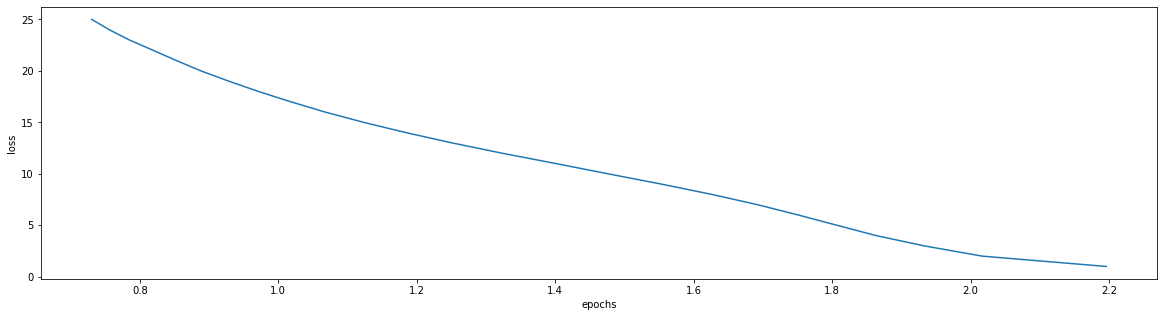

In [35]:
loss = history.history['loss']
plt.plot(loss,[epoch+1 for epoch in range(0,len(loss))])
plt.xlabel('epochs')
plt.ylabel('loss')

Text(0, 0.5, 'val_accuracy')

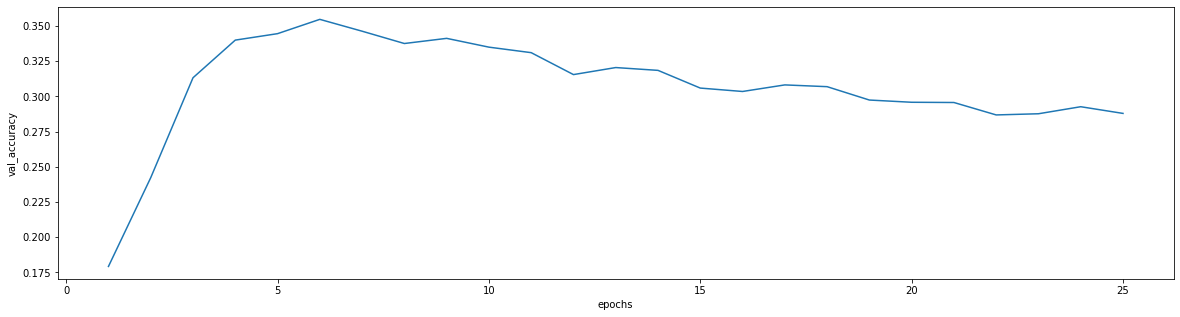

In [37]:
val_accuracy = history.history['val_accuracy']
plt.plot([epoch+1 for epoch in range(0,len(val_accuracy))],val_accuracy)
plt.xlabel('epochs')
plt.ylabel('val_accuracy')